In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import pickle
import os, re
import nltk
BASE_DIR = '../input/'
LABELED_TRAIN_DF = BASE_DIR + 'labeled_train_clean_reviews.csv'
TEST_DF = BASE_DIR + 'test_clean_reviews.csv'

In [2]:
labeled_train = pd.read_csv(LABELED_TRAIN_DF, header = 0)
test = pd.read_csv(TEST_DF, header = 0)
labeled_train["review"] = labeled_train["review"].astype(str)
test["review"] = test["review"].astype(str)
print "Read %d labeled train reviews" \
          "and %d test reviews" % (labeled_train["review"].size, test["review"].size)

Read 25000 labeled train reviewsand 25000 test reviews


Data leakage

Check if test["sentiment"] is correct

In [3]:
test["sentiment"] = test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)

Credits: Kaggle tutorial

In [4]:
from gensim.models import Word2Vec
EMBEDDING_DIM = 300  # Word vector dimensionality
MIN_WORD_COUNT = 40  # Minimum word count. Kaggle set to 40, to avoid attaching too much importance to individual movie titles.
NUM_THREADS = 4  # Number of threads to run in parallel
CONTEXT = 10  # Context window size
DOWNSAMPLING = 1e-3  # Downsample setting for frequent words
WORD2VEC_MODEL_FILE = BASE_DIR + \
    "word2vec_model_" + \
    str(EMBEDDING_DIM) + "dim_" + \
    str(MIN_WORD_COUNT) + "minwords_" + \
    str(CONTEXT) + "context"

word2vec_model = Word2Vec.load(WORD2VEC_MODEL_FILE)

# If you don't plan to train the model any further, calling
# init_sims will make the model much more memory-efficient.
word2vec_model.init_sims(replace=True)

print("Number of words in the word2vec model vocabulary: %d" % len(word2vec_model.wv.vocab))

Number of words in the word2vec model vocabulary: 16490


Prepare

In [5]:
train_clean_reviews = labeled_train["review"].tolist()
test_clean_reviews = test["review"].tolist()

all_clean_reviews = train_clean_reviews + test_clean_reviews

In [6]:
print(np.random.choice(all_clean_reviews, 1))

['i really wanted to like this movie  because it is refreshingly different from the hordes of everyday horror movie clones  and i appreciate that the filmmakers are trying for something original  unfortunately  the plot just didn t hold together and none of the characters were likable enough for me to really care about them or their fates visually  the toybox was pretty interesting  the director took a lot of somewhat risky moves  like adding in little bits of  flash looking  animation in parts and really cheesing up some of the special effects  such as the light from a certain amulet   sometimes this worked and sometimes it didn t  but he deserves kudos for the attempt  and the cinematography was generally of high quality unfortunately  when this same approach of throwing lots of things at the wall to see what sticks was applied to the plot  the results were not very good  the film never really finds a tone that it likes  moving schizophrenically from black comedy to family soap opera

In [7]:
# We vectorize the text corpus by turning each text into a sequence of integers
# Each integer is the index of a token in the dictionary
from keras.preprocessing.text import Tokenizer

MAX_NUM_WORDS_FOR_KERAS_TOKENIZER = 200000
#
# num_words: the maximum number of words to keep, based on frequency.
keras_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS_FOR_KERAS_TOKENIZER)
#
# fit_on_texts accepts a list of strings, a generator of strings or 
# a list of list of strings. In the last case, it assumes each entry of the lists to be a token.
# Here we provide a list of strings.
keras_tokenizer.fit_on_texts(all_clean_reviews)
word_index = keras_tokenizer.word_index
print('Keras Tokenizer found %s unique tokens' % len(word_index))
#
# texts_to_sequences transforms each text in texts to a sequence of integers.
train_sequences = keras_tokenizer.texts_to_sequences(train_clean_reviews)
test_sequences = keras_tokenizer.texts_to_sequences(test_clean_reviews)

Using TensorFlow backend.


Keras Tokenizer found 101376 unique tokens


In [8]:
# We pad all text sequences to the same length.
# By default zeros are padded at the front.
from keras.preprocessing.sequence import pad_sequences

# Set max length for each review sequence.
MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN = 500

train_pad_sequences = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN)
test_pad_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN)

In [9]:
# Prepare word embedding matrix

# Choose the smaller number of the two as column length of the matrix
num_words = min(MAX_NUM_WORDS_FOR_KERAS_TOKENIZER, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec_model.wv.vocab:
        embedding_matrix[i] = word2vec_model.wv.get_vector(word)
# Null word embeddings are words that don't exist in the embedding matrix
# and are therefore represented as zero vectors.
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 84920


In [10]:
# Split train_sequences into train and validation. Ratio: 80/20
VALIDATION_SPLIT = 0.2
np.random.seed(1234)

# 
perm = np.random.permutation(len(train_sequences))
index_train = perm[:int(len(train_sequences)*(1-VALIDATION_SPLIT))]
index_val = perm[int(len(train_sequences)*(1-VALIDATION_SPLIT)):]

x_train = train_pad_sequences[index_train]
x_val = train_pad_sequences[index_val]
y_train = labeled_train["sentiment"][index_train].tolist()
y_val = labeled_train["sentiment"][index_val].tolist()

print('Randomly split %d pad sequences for training, %d for validation' % (len(x_train) ,len(x_val)))


Randomly split 20000 pad sequences for training, 5000 for validation


In [11]:
x_test = test_pad_sequences
y_test = test["sentiment"]

## Model Architecture

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.initializers import Constant

In [13]:
def rnn_model():
    model = Sequential()
    
    # https://towardsdatascience.com/rnn-training-tips-and-tricks-2bf687e67527
    LSTM_UNITS = 32
    LSTM_DROPOUT = 0.
    LSTM_RECCURENT_DROPOUT = 0.
    
    # Embedding layer.
    # First two parameters are input_dim and output_dim.
    # weights, trainable are passed into **kwargs.
    # They are properties of the abstract base Layer class from which all layers inherit.
    embedding_layer = Embedding(
            num_words,
            EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN,
            trainable=False)
    lstm_layer = LSTM(LSTM_UNITS, dropout=LSTM_DROPOUT, 
                      recurrent_dropout=LSTM_RECCURENT_DROPOUT)
    output_layer = Dense(1, activation='sigmoid')
    
    model.add(embedding_layer)
    model.add(Dropout(0.2))
    model.add(lstm_layer)
    model.add(Dropout(0.2))
    model.add(output_layer)
    
    # Choose adam optimizer, binary crossentropy, ['accuracy'] metric.
    # https://www.dlology.com/blog/quick-notes-on-how-to-choose-optimizer-in-keras/
    # https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/
    # https://keras.io/getting-started/sequential-model-guide/
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model
    
    
    

In [14]:
lstm_model = rnn_model()

In [15]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          30413100  
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 30,455,757
Trainable params: 42,657
Non-trainable params: 30,413,100
_________________________________________________________________


In [16]:
# batch_size: number of samples per gradient update
history = lstm_model.fit(x_train, y_train, batch_size=64, epochs=6, validation_data=[x_val, y_val])

Train on 20000 samples, validate on 5000 samples
Epoch 1/6
20000/20000 [==============================] - 279s 14ms/step - loss: 0.4528 - acc: 0.7876 - val_loss: 0.3491 - val_acc: 0.8600
Epoch 2/6
20000/20000 [==============================] - 278s 14ms/step - loss: 0.3653 - acc: 0.8454 - val_loss: 0.3293 - val_acc: 0.8628
Epoch 3/6
20000/20000 [==============================] - 280s 14ms/step - loss: 0.3466 - acc: 0.8572 - val_loss: 0.3380 - val_acc: 0.8538
Epoch 4/6
20000/20000 [==============================] - 278s 14ms/step - loss: 0.3495 - acc: 0.8531 - val_loss: 0.3227 - val_acc: 0.8680
Epoch 5/6
20000/20000 [==============================] - 278s 14ms/step - loss: 0.3278 - acc: 0.8638 - val_loss: 0.3195 - val_acc: 0.8656
Epoch 6/6
20000/20000 [==============================] - 278s 14ms/step - loss: 0.3161 - acc: 0.8672 - val_loss: 0.3143 - val_acc: 0.8710


In [18]:
y_test_pred = lstm_model.predict(x_test)

In [19]:
y_test_pred_binary = map(lambda predict: 1 if predict > 0.5 else 0, y_test_pred)

In [20]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [21]:
print("The AUC score for LSTM model is : %.5f." %roc_auc_score(y_test, y_test_pred_binary))

The AUC score for LSTM model is : 0.87232.


In [22]:
# Write the test results
output = pd.DataFrame(data={"id": test["id"], "sentiment": y_test_pred_binary})
output.to_csv(os.path.join('../', 'output', "lstm_word2vec_32units_2dropout_6epoch.csv"), index=False, quoting=3)
print "Wrote to lstm_word2vec_32units_2dropout_6epoch.csv"

Wrote to lstm_word2vec_32units_2dropout_6epoch.csv


In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

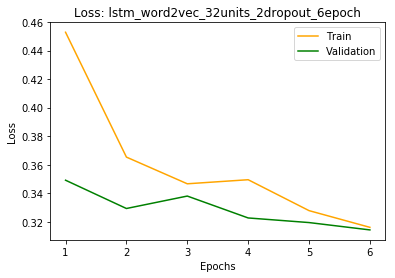

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, color='orange', label='Train')
plt.plot(epochs, val_loss, color='green', label='Validation')
plt.title('Loss: lstm_word2vec_32units_2dropout_6epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../figures/lstm_word2vec_32units_2dropout_6epoch_loss.png', dpi=900)

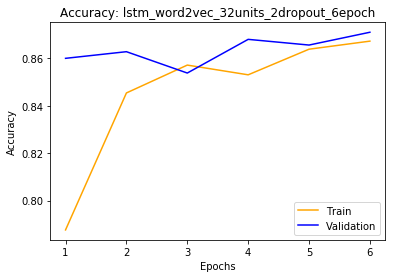

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, color='orange', label='Train')
plt.plot(epochs, val_acc, color='blue', label='Validation')
plt.title('Accuracy: lstm_word2vec_32units_2dropout_6epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../figures/lstm_word2vec_32units_2dropout_6epoch_accuracy.png', dpi=900)